# Subproject 1 – Used Car Prices Prediction
Machine Learning – M.Sc. in Electrical and Computer Engineering


Importing libraries

In [2]:
import pandas as pd

In [3]:
import numpy as np
import matplotlib.pyplot as plt


Reading datasets files and making dataframes using pandas library

In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Exploratory Data Analysis (EDA)

After reading and making DataFrames of the Datasets, i will be analysing the data.

Purpose:

This will let me understand the kind of datatype i am working.
It will let me understand the kind of features that are present in the Data, if they are categorical or numerical features.
If there there are missing values in the data, and the type (if any). This make me have better decision on methods i can use to fill up the values.

To do this i will be making use of some methods from the pandas library such as "shape()", "head()", "info()", "dtypes()", "describe()".

During this EDA, i wil also be exploring some other related and important part which wich will let me make better decision when training tdata.

using the shape() method, will give the dimension (row x columns) of the data i am working with.

In [5]:
# for train data

df_train.shape

(188533, 13)

In [6]:
# for test data

df_test.shape

(125690, 12)

the head() method will show first rows of data but limited, "n" can be passed as an argument, if we want specific amount of row to be shown.

passing n as an argument here will show the first n rows from index (0 to n-1).

In [7]:
# for train data

df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [8]:
# for test data

df_test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


Using info() method to see the summary details about the dataframes like the index, datatypes, columns, non-null values and the memory usage.

Ths method also shows the total numbers of values for each of the columns present in the datasets

In [9]:
#  for the train data

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [10]:
#  for the test data

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


Target visualization

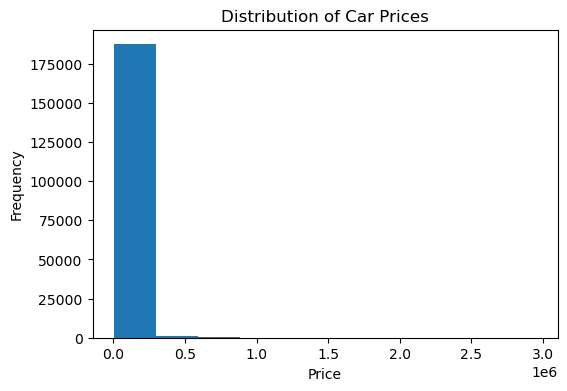

In [11]:
# from the price distribution plot below, it is noticed that the target ['price'] of the train data is skewed with fewer high-priced car.

# The target distribution was analyzed to identify skewness and outliers in used car prices, which directly affects model choice and potential target transformations.

# Due to the skewness from the target, we can make use of log transform, beacuse it compreses the high-price tail and also affect the proportionality of the errors.

# price distrubution  visualization
plt.figure(figsize=(6,4))
plt.hist(df_train["price"])
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

separating numerical column and categorical column:

this part shows the numerical columns and categorical features columns we have. Doing this made me understand the if there will be need for data encoding or not.

In [12]:
#  for train data

numerical_columns = df_train.select_dtypes(include=["int64", "float64"]).columns
categorical_columns = df_test.select_dtypes(include=["object", "bool", "category"]).columns


Missing values

the pandas library provides isnull() to check the column with missing values, sum() will give the total sum of the missing values if any exist,  and the sort_values() for sorting either in ascending or descending order.

In [13]:
# from pandas dataframe, we can use the .mean() method to find the mean for the each colums with missing values, then convert it to percentage multiplying be 100.

#  Missing value analysis was performed to quantify data incompleteness and justify the imputation strategies applied during preprocessing.

#  for train data
train_missing_values =df_train.isnull().sum().sort_values(ascending=False)
train_missing_columns = df_train.columns[df_train.isna().any()].tolist()

train_missing_percentage = df_train.isnull().mean().sort_values(ascending=False) * 100

train_missing_columns

['fuel_type', 'accident', 'clean_title']

In [14]:
#for test data

df_test.isnull().sum().sort_values(ascending=False)

train_missing_percentage[train_missing_percentage > 0]

clean_title    11.360876
fuel_type       2.696080
accident        1.300568
dtype: float64

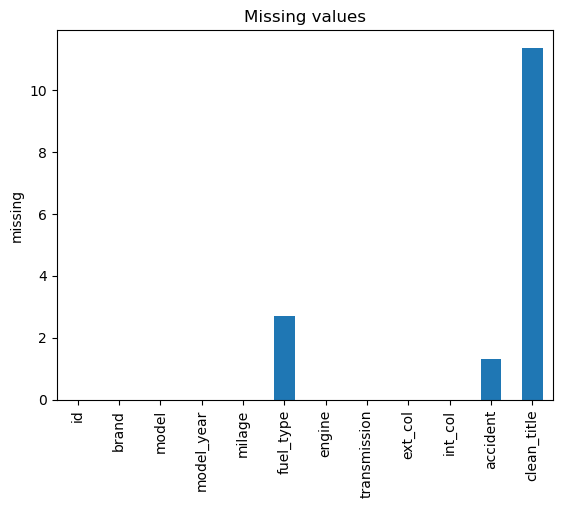

In [15]:
# the plot for columns with missing data
(df_train.drop(['price'], axis=1).isnull().mean() * 100).plot(kind="bar")
plt.title("Missing values")
plt.ylabel("missing")
plt.show()


# Data preprocessing

## Filling missing data

From using info() method when doing EDA above on the train data, It was seen that there are some missing values. Like in the fuel_type, accident and the clean_title features.

This missing values are categorical features, therefore there is need to fill the the missing values before training because model can not be trained without with NaNs.

In [16]:
# For replacing the missing values in the training set, i used the mode() function from pandas to get the mode and using fillna() function from pandas library  to fill the positions where there was a misiing values.

for column in train_missing_columns:
    #  calculates the mode of the values.
    replace_value = df_train[column].mode()[0]

    # then filled it to the missing values position.
    df_train[column] = df_train[column].fillna(replace_value)

# For the test set, only missing values for columns that are present in the train data set and excluding 'price was filled'.
# Doing this bring cosistency and more accuracy when training. As we are dealing with unseen data, we can't be sure if the unseen data will have additional column or not, or if they will contain some missing data, so it is best to take care of that.

#  this line will select only the column with missing data in test data that are also present in the train data
missing_columns_test = [col for col in train_missing_columns if col in df_test.columns]

for column in missing_columns_test:
    # Use the mode calculated from the training set for consistency
    replace_value = df_train[column].mode()[0]
    df_test[column] = df_test[column].fillna(replace_value)


In [17]:
#confirming if the missing data was successfully filled

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     188533 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      188533 non-null  object
 11  clean_title   188533 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     125690 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      125690 non-null  object
 11  clean_title   125690 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


## Encoding Categorical Features

it was seen from previous that there are some categorical features present in our datasets, there these categorical need to be encoded to be numerical features.

To do this, i used the get_dummies() method that implements OneHotEncoding of categorical data from the pandas library.

In [19]:
df_train_encoded = pd.get_dummies(df_train, drop_first=True)

df_test_encoded = pd.get_dummies(df_test, drop_first=True)
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.drop(['price'], axis=1).columns, fill_value=0)

In [20]:
df_train_encoded.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [21]:
df_train_encoded.head()

,id,model_year,milage,price,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,...,int_col_Tupelo,int_col_Very Light Cashmere,int_col_WHITE,int_col_Walnut,int_col_Whisper Beige,int_col_White,int_col_White / Brown,int_col_Yellow,int_col_–,accident_None reported
0,0,2007,213000,4200,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1,2002,143250,4999,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,2002,136731,13900,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,3,2017,19500,45000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,4,2021,7388,97500,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


<Axes: >

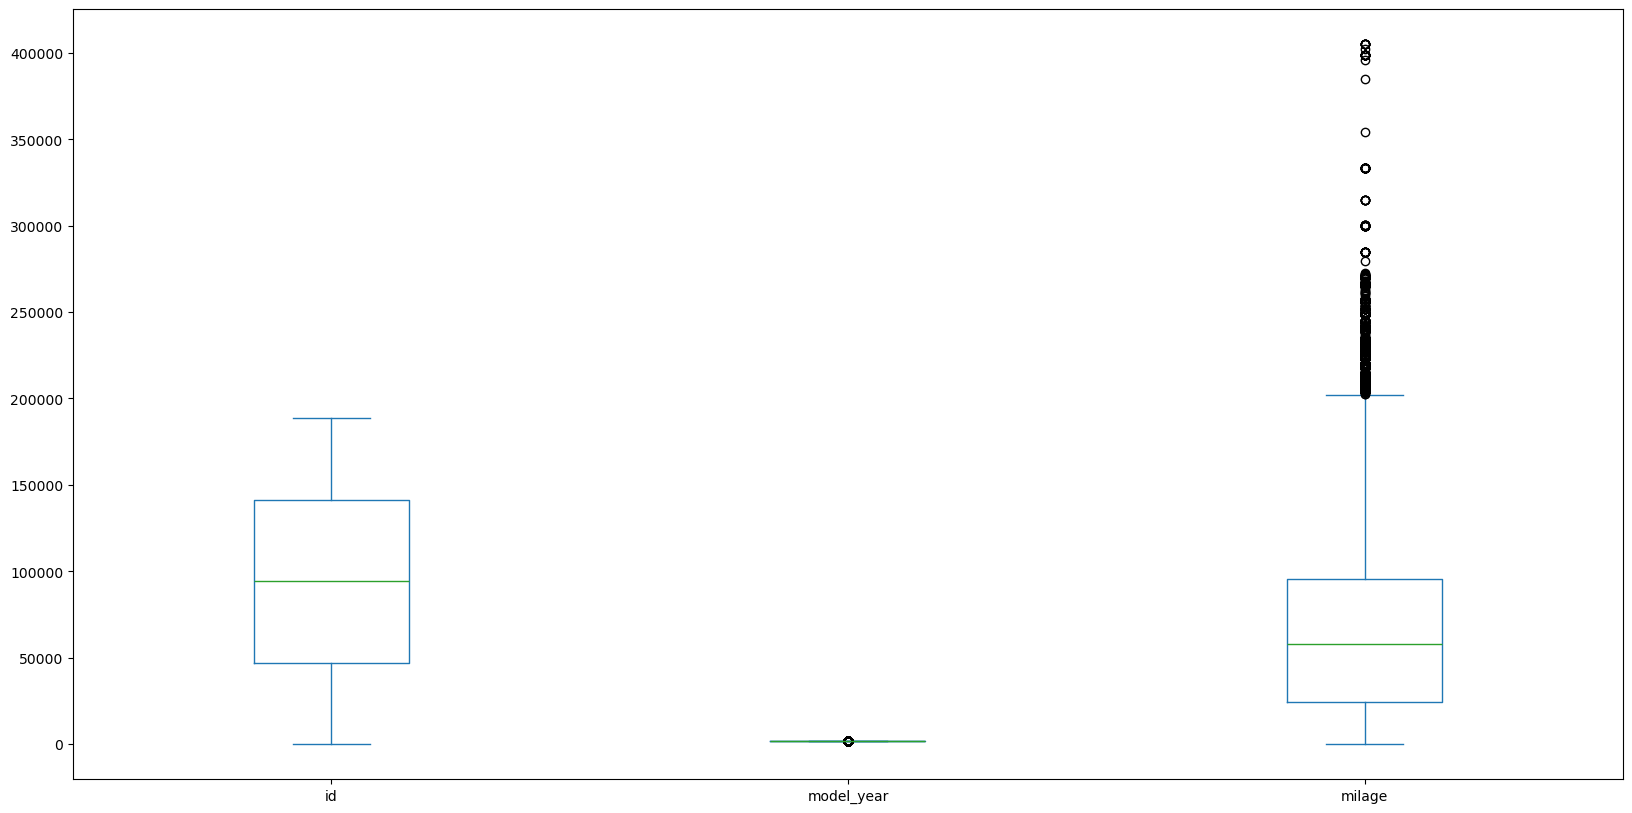

In [22]:
df_train_encoded.drop(['price'], axis=1).plot(kind='box', figsize=(20,10))

# Model Training

After I analyzed the Data, filled the columns with missing values and encoded the categorical features. Then i moved to training the model.

First aseline models without tuning or normalization

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

Created 2 functions

a. getXy : split the data to features and target
b. run_base_models: it will run base models inside it, plot and give the score for each of them

In [24]:
def getXy(df):
    X = df.drop(['price'], axis=1)
    y = df['price']

    return X,y

def run_base_models(df):
    X,y = getXy(df)
    # split the Dataframe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42, shuffle=True)

    #  basemodels to use
    base_models = {
    "Linear regression": LinearRegression(),
    "k-NN": KNeighborsRegressor(n_neighbors=3),
    "Decision tree": DecisionTreeRegressor(max_depth=50),
    "Random Forest": RandomForestRegressor(max_depth=50)
    }

    base_model_scores ={}

    for idx, (name, model) in enumerate(base_models.items()):
        fig,ax = plt.subplots(figsize=(20,10))

        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        pred = model.predict(X_test)

        # i used numpy to compute each base model rmse value
        rmse = np.sqrt(mean_squared_error(y_test, pred))

        print(f'{name}: score = {score}')

         # plot pred vs actual
        ax.scatter(y_test, pred, c='g', marker='o', linestyle='None')
        ax.plot(y_test, y_test, c='r')
        ax.set_ylabel('Predicted')
        ax.set_xlabel('Actual')
        ax.set_title(f'{name} / Score =  {score}/ RMSE = {rmse}')

        base_model_scores[name] = {"rmse": rmse}

    return base_model_scores

Runs the baseline models and plots predicted vs actual.

In [ ]:
models_scores = pd.DataFrame()
models_scores['Base Models'] = run_base_models(df_train_encoded)

Linear regression: score = 0.13610773205761584


**Features Engineering**

Log transform of the target

In [ ]:
delta = 1
X, y = getXy(df_train_encoded)
y_log = np.log(y+delta)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=.20, random_state=42, shuffle=True)

Training the models with tuned hyperparameters of the models using GridSearchCV

Defines grid search helper function with CV RMSE and predicted vs actual plots.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

results = []
best_models = {}

tune_idx = X_train.sample(n=35000, random_state=42).index
X_tune = X_train.loc[tune_idx]
y_tune = y_train.loc[tune_idx]

cv = KFold(n_splits=3, shuffle=True, random_state=42)

def run_gridsearch(name, model, grid):
    gs = GridSearchCV(
        estimator=model,
        param_grid=grid,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=1,
        verbose=1
    )
    gs.fit(X_tune, y_tune)

    # fitting with full samples
    best_models[name] = gs.best_estimator_.fit(X_train, y_train)

    rmse = -gs.best_score_
    results.append({"model": name, "rmse": rmse, "params": gs.best_params_})

    print(f"{name} | RMSE={rmse}")
    print(f"params={gs.best_params_} ")

    #  predicting with full fit model
    preds = gs.best_estimator_.predict(X_test)

    # Predicted vs actual plot for the best model
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.scatter(y_test, preds, c='g', alpha=0.5, label='Predicted')
    ax.plot(y_test, preds, c='g', marker='o', linestyle='None')
    ax.plot(y_test, y_test, c='r')
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Actual')
    ax.set_title(f"{name} / CV_RMSE={rmse}")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return gs

Runs grid search for Linear Regression.

In [ ]:
linreg_grid = {
    "fit_intercept": [True, False],
    "positive": [False, True]
}

run_gridsearch("linreg", LinearRegression(), linreg_grid)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


Runs grid search for k-NN.

In [ ]:
knn_grid = {
    "n_neighbors": [3, 7],
    "weights": ["uniform", "distance"],
    "p": [2],
}

run_gridsearch("knn", KNeighborsRegressor(), knn_grid)

Runs grid search for Decision Tree.

In [ ]:
dt_grid = {
    "max_depth": [None, 10],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 4],
    "ccp_alpha": [ 0.001, 0.01]
}

run_gridsearch("dt", DecisionTreeRegressor(), dt_grid)


Runs grid search for Random Forest.

In [ ]:
rf_grid = {
    "n_estimators": [200],
    "max_depth": [10, 20],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"],
    "bootstrap": [True]
}
run_gridsearch("rf", RandomForestRegressor(), rf_grid)

Builds and displays the sorted grid-search results table.

In [ ]:
results_df = pd.DataFrame(results).sort_values("rmse")
results_df


Kaggle Submission File Generation

Generates submission predictions from the best model and saves submission.csv.

In [ ]:
best_model_name = results_df.iloc[0]['model']

# Retrieve the best estimator
best = best_models[best_model_name]

# Make predictions on the test set
predictions_log = best.predict(df_test_encoded)

# Inverse transform the predictions back to the original scale
predictions = np.exp(predictions_log) - delta

# Create the submission DataFrame
submission_df = pd.DataFrame({'id': df_test['id'], 'price': predictions})

# Ensure prices are non-negative, as car prices cannot be negative
submission_df['price'] = submission_df['price'].apply(lambda x: max(0, x))

# Display the first few rows of the submission file
display(submission_df.head(50))

# Save to CSV for Kaggle submission
submission_df.to_csv('submission.csv', index=False)